forked from main iowa_redistricting on march 28

manually implementing algorithm described in Chen and Rodden (2013)

Shapefile dataframes used in this notebook

shapefile_iowa: MGGG stuff merged with census stuff

shapef_ia_proj: projected to UTM so we can run distance calculations on it

shapef_ia_fordistricting: 99 rows for each county, ready for initial allocation; made from deep copy of shapef_ia_proj

shapef_counties_for_realloc: made from a deep copy from shapef_ia_fordistricting; this has a num_switches column and a district column populated with the district assignment from the initial allocation

shapef_ia_initialdistricting: came from _fordistricting, went through the districting (step 1/2) process, and is now 4 rows
	as of Sept 18, not modified further for step 3/district balancing

shapef_ia_redist: this is a deep copy of shapef_ia_initialdistricting with a few dropped columns. This df is used for making new districts

In [1]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os       #mkdir
from scipy.sparse import csgraph #for laplacian
from scipy.linalg import null_space
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label,
                     ggtitle, element_blank, element_rect,
                     scale_fill_manual, theme_minimal, theme, scale_fill_cmap)
import math         ##for math.sqrt
import random       #for random selection of district to start with

# Prepping the census and geopandas dataframes

## Importing data

In [2]:
#census.csv is data from Secretary of State's office.
census_df=pd.read_csv('census.csv')
census_df['COUNTYFP10']=census_df['COUNTYFP10'].astype(str).str.pad(3,fillchar='0')
census_df.head()

,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,Adair,7496,001,41.328528,-94.478164
1,1,Adams,3704,003,41.021656,-94.696906
2,2,Allamakee,14061,005,43.274964,-91.382751
3,3,Appanoose,12317,007,40.744683,-92.870345
4,4,Audubon,5674,009,41.679178,-94.904312


In [3]:
#imports county shapefiles from MGGG
shapefile_iowa = gpd.read_file('IA_counties/IA_counties.shp').sort_values('NAME10',ignore_index=True)
shapefile_iowa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 57 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP10   99 non-null     object  
 1   COUNTYFP10  99 non-null     object  
 2   GEOID10     99 non-null     int64   
 3   NAME10      99 non-null     object  
 4   NAMELSAD10  99 non-null     object  
 5   ALAND10     99 non-null     int64   
 6   AWATER10    99 non-null     int64   
 7   INTPTLAT10  99 non-null     object  
 8   INTPTLON10  99 non-null     object  
 9   TOTPOP      99 non-null     int64   
 10  NH_WHITE    99 non-null     int64   
 11  NH_BLACK    99 non-null     int64   
 12  NH_AMIN     99 non-null     int64   
 13  NH_ASIAN    99 non-null     int64   
 14  NH_NHPI     99 non-null     int64   
 15  NH_OTHER    99 non-null     int64   
 16  NH_2MORE    99 non-null     int64   
 17  HISP        99 non-null     int64   
 18  H_WHITE     99 non-null     int64   
 19  H_

In [4]:
## Merging ONLY 2020 population numbers and county_id from census df into shapefile_iowa
shapefile_iowa = shapefile_iowa.merge(census_df[['COUNTYFP10','population','county_id']], on='COUNTYFP10').copy()

In [5]:
county_populations = np.array(census_df['population'])
state_population = sum(county_populations)
n_counties = 99
n_districts = 4

## Projecting shapefile to UTM 15N

In [6]:
#First, show the current coordinate reference system
shapefile_iowa.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [7]:
#Then project the shapefiles to UTM 15N
shapef_ia_proj = shapefile_iowa.to_crs(epsg=26915)

shapef_ia_proj.crs

<Derived Projected CRS: EPSG:26915>
Name: NAD83 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 96°W and 90°W - onshore and offshore. Canada - Manitoba; Nunavut; Ontario. United States (USA) - Arkansas; Illinois; Iowa; Kansas; Louisiana; Michigan; Minnesota; Mississippi; Missouri; Nebraska; Oklahoma; Tennessee; Texas; Wisconsin.
- bounds: (-96.0, 25.61, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
#checking out geopandas automatic distance calculation
shapef_ia_proj['geometry'].iloc[0].distance(shapef_ia_proj['geometry'].iloc[1])
# adair-to-adams distance is 0, so shortest distance, not centroid-to-centroid

0.0

## Merging pd and gpd dataframes and creating population heat map

In [9]:
## Merging ONLY lat/long + county id from census df into shapefile_iowa (since population and county_id are already there)
map_population_by_county_data = shapefile_iowa.merge(census_df[['COUNTYFP10','latitude','longitude']], on='COUNTYFP10').copy()

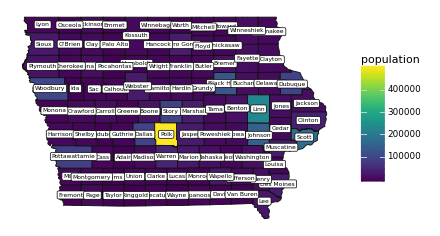

<ggplot: (322785827)>

In [10]:
map_population_by_county = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                     label='NAME10',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_population_by_county

In [11]:
#data_label: 'county_id', 'population', 'NAME10', 'county_id_string', etc
#second argument is the column from the dataframe that we want to sort by
#in our case, it should be 'DISTRICT' from the shapef_ia_redist dataframe
def distmap_by_county(map_data,data_label):
    plot_distmap = (
        ggplot(map_data)
    + geom_map(aes(fill='DISTRICT')
        ,show_legend=False
        ) 
    # + geom_map(aes(fill=str('district_number')))      #swap commenting on this line and the above to make district categorical!
    + geom_label(aes(x='xcentr_lon', y='ycentr_lat', label=data_label,size=2)
        , show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            # figure_size=(7, 4)      #this stretches shit?
            )
    # + scale_fill_manual(values=color_dict)        #uncomment this line to make district categorical!
    )
   
    return plot_distmap


# Creating distance matrix for Iowa counties

In [12]:
# adding/fixing columns with (projected) centroid locations 
shapef_ia_proj['xcentr_lon'] = shapef_ia_proj.centroid.x
shapef_ia_proj['ycentr_lat'] = shapef_ia_proj.centroid.y
#shapef_ia_proj.info()
# shapef_ia_proj['xcentr_lon'].iloc[1]

In [13]:
# cutting out other columns from the shapefile to be dissolved on

# 'TOTPOP' is the MGGG shapefile totpop (pre-2020), so removing
# also removing: the un-projected 'INTPTLAT10' and 'INTPTLON10'
#      and 'NAMELSAD10', the 2 word name
#      and all demographic/voting data
#      and (later on): also removing ALAND and AWATER, since they just get messy with merges and dissolves

districting_columns = ['COUNTYFP10', 'NAME10', 'geometry', 
       'population', 'county_id', 'xcentr_lon', 'ycentr_lat']

#make a new shapefile, which will be merged/dissolved on in the process of making districts
shapef_ia_fordistricting = shapef_ia_proj[districting_columns].copy()

#add column of county indices (which will get concatenated, as county_id_string)
shapef_ia_fordistricting['county_id_string'] = shapef_ia_fordistricting['county_id']
shapef_ia_fordistricting['county_id_string'] = shapef_ia_fordistricting['county_id_string'].astype(str).str.pad(2,fillchar='0')

#add column of county indices (which will become district indices)
shapef_ia_fordistricting['temp_district'] = shapef_ia_fordistricting.index

shapef_ia_fordistricting.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   COUNTYFP10        99 non-null     object  
 1   NAME10            99 non-null     object  
 2   geometry          99 non-null     geometry
 3   population        99 non-null     int64   
 4   county_id         99 non-null     int64   
 5   xcentr_lon        99 non-null     float64 
 6   ycentr_lat        99 non-null     float64 
 7   county_id_string  99 non-null     object  
 8   temp_district     99 non-null     int64   
dtypes: float64(2), geometry(1), int64(3), object(3)
memory usage: 7.7+ KB


# Nearest-Neighbor district-building model

* To start, we have 99 districts, 1 for each county.
* Randomly select a district (single county at the moment!) to start with.
* Join it to its nearest neighbor (using centroid measurement of distance).
    * Make new shapefile with those two counties dissolved together (and calc new centroids/distances)
    * Now we have 98 districts. Repeat until 4 left.

This procedure preserves compactness well, but has no population controls.
After we're down to 4 districts, we will then swap counties between districts until populations stabilize.


## Building-block functions (adjacency matrix + distance matrix)

In [14]:
# function for arbitrary adjacency matrix
# updated to no longer classify kitty-corner as "adjacent", Oct 30

def adj_mat_calc(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    adjac_mat = pd.DataFrame()

    for i in range(curr_n_districts):
        adjac_mat[i] = temp_shapefile.intersection(temp_shapefile.iloc[[i]].unary_union).length
    
    #sign function turns all nonzero entries to 1
    adjac_mat = np.sign(adjac_mat)

    #eliminate diagonals, so county i is not adjacent to itself
    adjac_mat = adjac_mat - np.identity(curr_n_districts)

    # make everything an integer
    adjac_mat = adjac_mat.astype(int)

    #and/or boolean?
    # ia_adjac_matrix_bool = ia_adjac_matrix.astype(bool)

    return adjac_mat

In [15]:
#function: input is a shapefile with centroid columns, output is a distance matrix
def temp_distance_matrix(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    distance_mat = np.zeros((curr_n_districts,curr_n_districts))

    for i in range(curr_n_districts):
        for j in range(i):      #just do half the triangle, so indices from 0 to i-1
            x_dist = (temp_shapefile['xcentr_lon'].iloc[i] - temp_shapefile['xcentr_lon'].iloc[j])
            y_dist = (temp_shapefile['ycentr_lat'].iloc[i] - temp_shapefile['ycentr_lat'].iloc[j])
            distance_mat[i,j] = math.sqrt(x_dist**2 + y_dist**2)
            distance_mat[j,i] = math.sqrt(x_dist**2 + y_dist**2)

    return distance_mat


## full step 1/2 algorithm with iterability

In [16]:
shapef_ia_initialdistricting = shapef_ia_fordistricting.copy()


random.seed(2)      #for initial replicability while building.
#                    #if seed = 2, then this starts with the county with 7, Boone County.
        #first runthrough: 7 selected, 36 neighbor (merged is labeled as 7)
        #second runthrough: 11 selected, 33 is neighbor (merged is labeled as 11)

for i in range(95): ##### 95 iterations brings us from 99 districts to 4
    #how many districts are we working with this time?
    running_ndistricts = len(shapef_ia_initialdistricting)

    # pick out a district to work on on this iteration of the loop
    running_index = random.randint(0,running_ndistricts-1)        

    #find the temp_district associated with the running index
    #     the below was returning a slice of a dataframe, and not just the entry
    # running_temp_dist = shapef_ia_initialdistricting.loc[shapef_ia_initialdistricting.index == running_index, 'temp_district']
    running_temp_district = shapef_ia_initialdistricting['temp_district'].iloc[running_index]
    #     originally just called this for the print statement
         

    #set up adjacency and distance matrices
    running_adjmat = adj_mat_calc(shapef_ia_initialdistricting)
    running_distmat = temp_distance_matrix(shapef_ia_initialdistricting)

    print("On loop # %d (with %d districts remaining), we have selected index %d. \
    \n This corresponds to county id %s and temporary district # %d."   \
        % (i+1, running_ndistricts,running_index,   \
           shapef_ia_initialdistricting['county_id_string'].iloc[running_index], \
           running_temp_district) )
    
    #------find closest neighbor: could use cleaning up/making better
    distance_list = list(running_distmat[running_index])
    # distance_list.index(0)      # the index of the element with value 0 is 7

    # sorting is inefficient, maybe fix
    # https://stackoverflow.com/questions/26779618/python-find-second-smallest-number

    neighbor_dist = sorted(distance_list)[1]           #second smallest distance is nearest neighbor (since distance to self is zero)
    ##                                                    ### OR! check on adjacency matrix first!
    neighbor_index = distance_list.index(neighbor_dist)     #county 36 (Greene) is closest to county 7 (Boone)
    
    # the temp_district number associated with the neighbor_index
    # the below was having iiiiissues
    #     neighbor_temp_dist = shapef_ia_initialdistricting.loc[shapef_ia_initialdistricting.index ==neighbor_index, 'temp_district']
    neighbor_temp_district= shapef_ia_initialdistricting['temp_district'].iloc[neighbor_index]
    #   this doesn't really get used except to print? but running_temp_district is super important for re-indexing

    # print("The nearest neighbor index is %d, representing county id %s and temporary district # %d." \
    #     % (neighbor_index,   \
    #        shapef_ia_initialdistricting['county_id_string'].iloc[neighbor_index],\
    #        neighbor_temp_district) )
    #---------end finding closest neightbor

    # re-index the neighbor county to be in the first county's district
    shapef_ia_initialdistricting.loc[shapef_ia_initialdistricting.index == neighbor_index, 'temp_district'] = running_temp_district      


    # dissolve shapefile based on temp_district to combine the two counties
    #aggregate remaining columns by summing them

    # arguments for aggfunc: https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html
    shapef_ia_initialdistricting = shapef_ia_initialdistricting.dissolve(
        by="temp_district",
        aggfunc = {
            "COUNTYFP10": "sum",    #sum = concatenation here b/c string
            "NAME10": "count",      #kind of dummy: will be 2 only for most-recently-merged district
            "population": "sum",
            "county_id": "sum",     #should be actual sum here, kind of dummy
            "xcentr_lon": "first",  #dummy, since we'll recalculate
            "ycentr_lat": "first",
            "county_id_string": "sum", #sum = concatenation here b/c string
            "temp_district": "first"
        }
    )

    # update centroid lat/longs!
    shapef_ia_initialdistricting['xcentr_lon'] = shapef_ia_initialdistricting.centroid.x
    shapef_ia_initialdistricting['ycentr_lat'] = shapef_ia_initialdistricting.centroid.y

    #the dissolve process makes the temp_district column into the index of the dataframe
    #which then has issues when we iterate the process
    #so dump the index for a dummy one now
    shapef_ia_initialdistricting = shapef_ia_initialdistricting.reset_index(drop=True)


    print("Districts remaining:", len(shapef_ia_initialdistricting))  #print how many districts are left

# shapef_ia_initialdistricting = shapef_ia_initialdistricting.copy()


On loop # 1 (with 99 districts remaining), we have selected index 7.     
 This corresponds to county id 07 and temporary district # 7.
Districts remaining: 98
On loop # 2 (with 98 districts remaining), we have selected index 11.     
 This corresponds to county id 11 and temporary district # 11.
Districts remaining: 97
On loop # 3 (with 97 districts remaining), we have selected index 10.     
 This corresponds to county id 10 and temporary district # 10.
Districts remaining: 96
On loop # 4 (with 96 districts remaining), we have selected index 46.     
 This corresponds to county id 49 and temporary district # 49.
Districts remaining: 95
On loop # 5 (with 95 districts remaining), we have selected index 21.     
 This corresponds to county id 22 and temporary district # 22.
Districts remaining: 94
On loop # 6 (with 94 districts remaining), we have selected index 85.     
 This corresponds to county id 90 and temporary district # 90.
Districts remaining: 93
On loop # 7 (with 93 districts

In [17]:
# these were used to check which counties (via IDs and FIPs) were in each district
# list(shapef_ia_initialdistricting["county_id_string"])
# list(shapef_ia_initialdistricting["COUNTYFP10"])

### plot maps of new districts

In [18]:
shapef_ia_initialdistricting['combined_label'] = shapef_ia_initialdistricting['population'].astype(str)  + str(' (dist ') + shapef_ia_initialdistricting['temp_district'].astype(str) + str (')')
shapef_ia_initialdistricting['combined_label']
# shapef_ia_initialdistricting.info()

0     133122 (dist 42)
1     412348 (dist 61)
2     385133 (dist 74)
3    2259766 (dist 94)
Name: combined_label, dtype: object

### functions that draw maps

In [19]:
#label_field: 'population', 'temp_district', 'combined_label'
def map_merged_districts(new_shapefile,label_field):
    map_population_by_district = (
        ggplot(new_shapefile)
        + geom_map(aes(fill='population'))
        + geom_label(aes(x='xcentr_lon', y='ycentr_lat', 
                        label=(label_field),size=2), 
                    show_legend=False)
        + theme_minimal()
        + theme(axis_text_x=element_blank(),
                axis_text_y=element_blank(),
                axis_title_x=element_blank(),
                axis_title_y=element_blank(),
                axis_ticks=element_blank(),
                panel_grid_major=element_blank(),
                panel_grid_minor=element_blank()
            )
        + scale_fill_cmap(#cmap_name="PiYG",
           limits=[0,1500000])
        )

    return map_population_by_district

#input: shapefile of counties within a particular district 
#   (after undergoing identity overlay)
#   label_field options: 'NAME10', 'population_2', 'county_id', 'county_id_string_2', etc
def map_unmerged_districts(new_shapefile,label_field):
    map_counties_by_district = (
        ggplot(new_shapefile)
        + geom_map(aes(fill='population_2'))
        + geom_label(aes(x='xcentr_lon_2', y='ycentr_lat_2', 
                        label=label_field,size=2), 
                    show_legend=False)
        + theme_minimal()
        + theme(axis_text_x=element_blank(),
                axis_text_y=element_blank(),
                axis_title_x=element_blank(),
                axis_title_y=element_blank(),
                axis_ticks=element_blank(),
                panel_grid_major=element_blank(),
                panel_grid_minor=element_blank()
            )
        )

    return map_counties_by_district

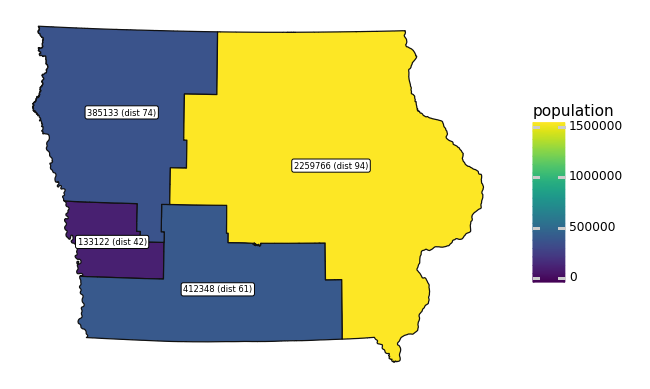

<ggplot: (323918770)>

In [20]:
map_merged_districts(shapef_ia_initialdistricting,'combined_label')

In [21]:
shapef_ia_initialdistricting[['population','temp_district']]

,population,temp_district
0,133122,42
1,412348,61
2,385133,74
3,2259766,94


# Begin step 3: redistributing counties until population is within bounds

## Helper Functions

In [22]:
# helper function: input is a shapefile with 'population' 
# column. output is a full matrix with SIGNED
# population differences between attributes
# row - col
# positive value in row i column j means that pop(i) > pop(j)
# negative value in row i column j means that pop(i) < pop(j)
def pop_diff_matrix(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    pop_diff_mat = np.zeros((curr_n_districts,curr_n_districts))

    for i in range(curr_n_districts):
        for j in range(curr_n_districts):   
            pop_diff_mat[i,j] = temp_shapefile['population'].iloc[i] - temp_shapefile['population'].iloc[j]
    
    return pop_diff_mat


## helper function: given a dataframe of movable counties
# and another dataframe of the district they're going to
# make a list of relative distances
def calculate_rel_dist(border_counties,new_district):
    n_border_counties = len(border_counties)
    distance_list = np.zeros((n_border_counties,3))

    for i in range(n_border_counties):
        oldx_dist = border_counties['xcentr_lon_2'].iloc[i] - border_counties['xcentr_lon_1'].iloc[i]
        oldy_dist = border_counties['ycentr_lat_2'].iloc[i] - border_counties['ycentr_lat_1'].iloc[i]

        # old_dist
        distance_list[i,0] = math.sqrt(oldx_dist**2 + oldy_dist**2)

        newx_dist = border_counties['xcentr_lon_2'].iloc[i] - new_district['xcentr_lon'].iloc[0]
        newy_dist = border_counties['ycentr_lat_2'].iloc[i] - new_district['ycentr_lat'].iloc[0]

        # new_dist
        distance_list[i,1] = math.sqrt(newx_dist**2 + newy_dist**2)

        ## relative_distance: old - new
        # we'll move the county with highest relative distance
        distance_list[i,2] = distance_list[i,0] - distance_list[i,1]

    #we only need relative distances, not the component parts
    #so we could just make an n x 1 list instead of n x 3
    rel_dist = distance_list[:,2]
    return rel_dist

#-----------module to find neighboring districts with the greatest population difference---------------------
def neighbor_popdiff_fun(df):
    #adjacencey matrix for 4 districts
    adj_mat_array = adj_mat_calc(df).to_numpy()   

    #SIGNED population difference array
    # row minus col
    # positive value in row i column j means that pop(i) > pop(j)
    # negative value in row i column j means that pop(i) < pop(j)
    pop_diff_array = pop_diff_matrix(df)
    # zero out any pairs that aren't adjacent
    # for numpy arrays, "*" is piecewise multiplication
    neighbor_popdiff = adj_mat_array * pop_diff_array

    return neighbor_popdiff

In [23]:
#Identify the border counties between the two districts with biggest population difference
#return a dataframe with the border counties with a column of relative distances between the big and small districts
def border_counties_df_func(shapef_ia_redist, list_of_districts, list_of_counties):
    neighbor_popdiff=neighbor_popdiff_fun(shapef_ia_redist)
    #popdiff_locs is a list of ordered pairs giving the location of the
    #positive values within neighbor_popdiff corresponding to adjacent districts. Note!! Indexed on (0,n-1)!
    popdiff_locs=np.argwhere(neighbor_popdiff>0)
    # maxpopdiff_loc = np.unravel_index(np.argmax(neighbor_popdiff, axis=None),   neighbor_popdiff.shape)

    big_dist_list=[]
    small_dist_list=[]
    pop_limit_switch_list=[]
    
    for i in range(popdiff_locs.shape[0]):
        big_dist_index=popdiff_locs[i][0]
        big_dist_list.append(big_dist_index)
        small_dist_index=popdiff_locs[i][1]
        small_dist_list.append(small_dist_index)
        pop_limit_switch=.75*neighbor_popdiff[big_dist_index][small_dist_index]
        pop_limit_switch_list.append(pop_limit_switch)

    df=pd.DataFrame()
    df['big_dist_index']=big_dist_list #goes from 0 to 3
    df['small_dist_index']=small_dist_list #goes from 0 to 3
    df['small_dist']=[x+1 for x in small_dist_list] #goes from 1 to 4
    df['big_dist']=[x+1 for x in big_dist_list] #goes from 1 to 4
    df['pop_limit_switch']=pop_limit_switch_list

    df=df.sort_values('pop_limit_switch', ascending=False).reset_index(drop=True)
    #Note: pop_limit_switch is a proxy for actual pop limits and we can sort off of this list. But we need to make sure other lists are sorted accordingly


    #----------find which county will be swapped from "bigdist" to  "smalldist"----------------------
    #from the list of 4 dataframes (each of diff districts)
    #we call the dataframe of the big district

        #dataframe of counties in the Big district which are 
    #adjacent to the Small district so which we might move
    #(possible to be point neighbors and have issues -
    #should be okay with D criterion, though)
    #reset index so it is (0,n-1), instead of sparse indexing based on where the county     was within the district
    #we retain the original county id in 'county_id'

    small_dist_list_for_border_counties=[]
    big_dist_counties_list=[]
    bigdist_movable_list=[]
    for j in range(popdiff_locs.shape[0]):
        # small_dist_list_for_border_counties=[x-1 for x in small_dist_list]
        small_dist_list_for_border_counties.append(list_of_districts[df.loc[j,'small_dist_index']])
        big_dist_counties_list.append(list_of_counties[df.loc[j, 'big_dist_index']])
        
        #update Nov 1
        #intersection  and .length finds the length of intersection
        #   of each county from the big district with the entirety of the small district
        #np.sign turns nonzero entries to 1s
        temp_movable_ones = np.sign(big_dist_counties_list[j].intersection(small_dist_list_for_border_counties[j].unary_union).length)
        temp_movable_boolean = temp_movable_ones.astype(bool)
        bigdist_movable_list.append(big_dist_counties_list[j].loc[temp_movable_boolean].reset_index(drop=True).copy())
        # end Nov 1 update

        #update the .intersects so that it avoids kitty corners
        # bigdist_movable_list.append(big_dist_counties_list[j].loc[big_dist_counties_list[j].intersection(small_dist_list_for_border_counties[j].unary_union)].reset_index(drop=True).copy())
        bigdist_movable_list[j]['relative_distance']=calculate_rel_dist(bigdist_movable_list[j], small_dist_list_for_border_counties[j])

      

    # adding column to bigdist_movable with relative distances
    # bigdist_movable['rel_distance'] = calculate_rel_dist(bigdist_movable,smalldist)
    # return bigdist_movable, pop_limit_switch, small_dist_index

    return bigdist_movable_list, df['pop_limit_switch'].tolist(), df['small_dist'].tolist(), df['big_dist_index'].tolist()

In [24]:
# helper function
# input is a shapefile with attributes of single counties (and columns as labeled below)
#       usually:  shapef_ia_step3
# output is a shapefile with attributes of districts
#       usually: shapef_step3_dissolved

def dissolve_by_district(county_shapefile):
    dissolved_shapefile = county_shapefile.dissolve(
        by="DISTRICT",
        aggfunc = {
            "population": "sum",
            "xcentr_lon": "first",  #dummy, since we'll recalculate
            "ycentr_lat": "first",
            #skip the county_id_string now since we aren't slicing it
            # "county_id_string": "sum", #sum = concatenation here b/c string
            "DISTRICT": "first"
        }
    )
    dissolved_shapefile['xcentr_lon'] = dissolved_shapefile.centroid.x
    dissolved_shapefile['ycentr_lat'] = dissolved_shapefile.centroid.y

    #the dissolve process makes the temp_district column into the index of the dataframe
    #which then has issues when we iterate the process
    #so dump the index for a dummy one now
    dissolved_shapefile = dissolved_shapefile.reset_index(drop=True)

    return dissolved_shapefile

#gives a range for district size based off of ideal district size
def ideal_district_size_func(state_population, n_districts, tolerance):
    ideal_district_size=state_population/n_districts
    district_maximum=int(ideal_district_size*(1+tolerance))
    district_minimum=int(ideal_district_size*(1-tolerance))
    return district_minimum, district_maximum

In [25]:
#helper function to check for contiguity of big district as switch_func identifies a county
#to move from the big district to the small district

#note to self: moving_index=dataframe_sorted.iloc[i]['county_id']
def big_dist_contiguity_check_func(moving_index, big_dist_df):
    df=big_dist_df.loc[big_dist_df['county_id']!=moving_index]
    big_dist_laplacian=csgraph.laplacian(adj_mat_calc(df).to_numpy())
    return  null_space(big_dist_laplacian).shape[1]

def small_dist_contiguity_check_func(moving_index, border_counties, small_dist_df):
    moving_candidate=border_counties.loc[border_counties['county_id']==moving_index]
    df=small_dist_df.append(moving_candidate)
    small_dist_laplacian=csgraph.laplacian(adj_mat_calc(df).to_numpy())
    return null_space(small_dist_laplacian).shape[1]

In [26]:
#modifying switch_threshold_func to take a list of dataframes as an argument
def switch_threshold_func(dataframe_movable_list):
    switches_threshold=[]
    for j in range(len(dataframe_movable_list)):
        # array with all switch counts from the movable county list
        num_switches_array = np.array(dataframe_movable_list[j]['num_switches'])

        # max and min values from the array
        max_switches = max(num_switches_array)
        min_switches = min(num_switches_array)
        # our chosen threshold for switches: halfway between max and min (floor)
        if max_switches<4:
            switches_threshold.append(max_switches)
        else:
            switches_threshold.append(min_switches + np.ceil((max_switches-min_switches)*.75))
    return switches_threshold

# switch_func helper function
# input is a dataframe with potentially movable counties (and a count of switches)
# output is a county to switch: first priority: below threshold of switches (and population)
#    Then, max relative distance of what's left
def switch_func(big_dist_list, list_of_counties, dataframe_movable_list,switches_threshold_list,pop_limit_switch_list,small_dist_list):
    for j in range(len(dataframe_movable_list)):
        dataframe_sorted = dataframe_movable_list[j].sort_values('relative_distance',ascending=False).copy()
        switches_threshold = switches_threshold_list[j]
        pop_limit_switch = pop_limit_switch_list[j]
        for i in range(dataframe_sorted.shape[0]):
            # if dataframe_sorted.iloc[i]['num_switches'] <= switches_threshold:
            #     return dataframe_sorted.iloc[i]['county_id']
            #commenting out the if statement below to get rid of population threshold criteria - see if that'll eliminate discontiguous districts
            big_dist_index=big_dist_list[j]
            small_dist_index=small_dist_list[j]
            # if (dataframe_sorted.iloc[i]['num_switches'] <= switches_threshold) & (dataframe_sorted.iloc[i]['population_2']<pop_limit_switch) &(big_dist_contiguity_check_func(dataframe_sorted.iloc[i]['county_id'],list_of_counties[big_dist_index])==1)&(small_dist_contiguity_check_func(dataframe_sorted.iloc[i]['county_id'],dataframe_sorted,list_of_counties[small_dist_index])==1):
            if (dataframe_sorted.iloc[i]['num_switches'] <= switches_threshold) & (dataframe_sorted.iloc[i]['population_2']<pop_limit_switch) &(big_dist_contiguity_check_func(dataframe_sorted.iloc[i]['county_id'],list_of_counties[big_dist_index])==1):
                return dataframe_sorted.iloc[i]['county_id'], small_dist_list[j]
            # if (dataframe_sorted.iloc[i]['population_2']<pop_limit_switch) &(big_dist_contiguity_check_func(dataframe_sorted.iloc[i]['county_id'],list_of_counties[big_dist_index])==1):
            #     return dataframe_sorted.iloc[i]['county_id'], small_dist_list[j]
                break

## Main part of reallocation

Pseudo code for initial allocation and reallocation:
(COMPLETED ON 9/20)

1. Initial allocation (complete)
    - Prep gpdf for initial allocation
    - Create the dataframe with all 99 counties and their district assignments (shapef_ia_fordistricting)
    - Treat all 99 counties as its own district
    - Pick an initial random seed county and merge with its nearest neighbor
    - Repeat above step until there are only 4 districts left
    - Get dataframes for each district and convert to gpdf
2. Process data from initial allocation
    - Compute adjacency matrices for districts and population differences between districts (modules complete)
    - Create dataframes for 99 counties with district information and districts with shapefile information (complete)
3. Redistributing districts to balance out population
    - Identify border counties for the pair of adjacent districts that have the greatest population difference (module complete)
    - Identify county amongst border counties that satisfies mininum relative distance, population, and number of switches criteria (modules complete)
    - Switch the county from the larger to the smaller district and update its district label in the shapef_ia_fordistricting dataframe
    - Update populations in the districts and rerun steps 4-7 until populations of each district falls within specified size requirements

### Begin reallocation

In [27]:


# https://www.freecodecamp.org/news/creating-a-directory-in-python-how-to-create-a-folder/
# specify the path for the directory – make sure to surround it with quotation marks
path = './images'

# check whether directory already exists
#if yes, empty the folder
if not os.path.exists(path):
  os.mkdir(path)
  print("Folder %s created!" % path)
else:
  files = glob.glob('./images/*')
  for f in files:
    os.remove(f)

In [28]:
# adding switch_count to county shapefile which we will be using
shapef_counties_for_realloc = shapef_ia_fordistricting.copy()

# make a column with num_switches
shapef_counties_for_realloc['num_switches'] = np.zeros(shapef_counties_for_realloc.shape[0],dtype=int)

#9/13 note: update names of shapef_ia_redist to make sure it's clear what is in the rows.
# drop: 'NAME10' (was just "2" for most-recently-merged attribute)
#       'COUNTYFP10' (concatenated FIPS code)
#       'county_id'  (summed county ids) 
#       'temp_district'  (1 arbitrary "root" county code) 
shapef_ia_redist = shapef_ia_initialdistricting.drop(columns=['NAME10', 'COUNTYFP10','county_id','temp_district']).copy()

# make a column with a district #, 1-4
shapef_ia_redist['district_label'] = shapef_ia_redist.index + 1

In [29]:
output_df_forcsv = pd.DataFrame(columns= ['iteration','county_id', 'county_name','number_of_switches','old_district','new_district','dist1_pop','dist2_pop','dist3_pop','dist4_pop'])

for k in range(90):
   # Making separate geodataframes for each district (one district/attribute in each).
   list_of_districts=[]
   for i in range(4):
       list_of_districts.append(shapef_ia_redist.iloc[[i]].reset_index(drop=True))


   #the identity overlay takes district n and splits it up by all counties
   # which fall inside it (from main, un-districted shapefile)
   #keep_geom_type=True   discards boundary points and lines from counties which only border the district
   #resulting dataframe columns: _1 stuff comes from parent (whole district)
   #                             _2 stuff comes from specific county
   list_of_counties=[]
   for i in range(4):
       list_of_counties.append(list_of_districts[i].overlay(shapef_counties_for_realloc,how='identity',keep_geom_type=True))


   #this records the district number each county is assigned to in the first pass
   shapef_counties_for_realloc['DISTRICT']=''
   for i in range(99):
       for j in range(4):
           # if i<j:
           if shapef_counties_for_realloc.iloc[i]['COUNTYFP10'] in list_of_counties[j]['COUNTYFP10'].tolist():
               shapef_counties_for_realloc.loc[i,'DISTRICT']=j+1
   # shapef_counties_for_realloc

   border_counties_df_func_outputs=border_counties_df_func(shapef_ia_redist, list_of_districts, list_of_counties)
   bigdist_movable_list=border_counties_df_func_outputs[0]
   pop_limit_switch_list=border_counties_df_func_outputs[1]
   small_district_list = border_counties_df_func_outputs[2]
   big_district_list = border_counties_df_func_outputs[3]
  
   # bigdist_movable
   switches_threshold_list=switch_threshold_func(bigdist_movable_list)

   switch_func_output=switch_func(big_district_list,list_of_counties, bigdist_movable_list, switches_threshold_list,pop_limit_switch_list,small_district_list)

   # What county should be switched? Humboldt! (FIPS 091/id 45)
   movingcounty_index=switch_func_output[0]
   # print(movingcounty_index)


#    print("Iteration %d. The county id to move is %d." \
#        % (k+1,           
#            movingcounty_index
#           ) )

   # Update 99 row dataframe:
   old_district = shapef_counties_for_realloc.loc[movingcounty_index,'DISTRICT']
   shapef_counties_for_realloc.loc[movingcounty_index,'DISTRICT'] = switch_func_output[1]
   shapef_counties_for_realloc.loc[movingcounty_index,'num_switches'] = shapef_counties_for_realloc.loc[movingcounty_index,'num_switches']+1

   # overwriting old 4 row geodataframe with the new version (dissolved based on updated district number)
   shapef_ia_redist = dissolve_by_district(shapef_counties_for_realloc)

   #print(shapef_ia_redist['population'].to_list())
   iter_number=str(k+1).rjust(2,'0')
   im1 = map_merged_districts(shapef_ia_redist,'DISTRICT')
   im1 = im1.save("images/iter_{}.png".format(iter_number),verbose=False)       #verbose=False suppresses warnings
  
   district_min=ideal_district_size_func(state_population, n_districts, .01)[0]
   district_max=ideal_district_size_func(state_population, n_districts, .01)[1]


   output_df_forcsv = output_df_forcsv.append({'iteration': k+1,
                                               'county_id': movingcounty_index,
                                               'county_name': shapef_counties_for_realloc.loc[shapef_counties_for_realloc['county_id']==movingcounty_index]['NAME10'].values[0],
                                               'number_of_switches':shapef_counties_for_realloc.loc[shapef_counties_for_realloc['county_id']==movingcounty_index]['num_switches'].values[0],
                                               'old_district': old_district,
                                               'new_district': shapef_counties_for_realloc.loc[movingcounty_index,'DISTRICT'],
                                               'dist1_pop': shapef_ia_redist.loc[0,'population'],
                                               'dist2_pop': shapef_ia_redist.loc[1,'population'],
                                               'dist3_pop': shapef_ia_redist.loc[2,'population'],
                                               'dist4_pop': shapef_ia_redist.loc[3,'population']},
                                               ignore_index=True)

   if shapef_ia_redist['population'].max() in range(district_min, district_max+1) and shapef_ia_redist['population'].min() in range(district_min, district_max+1):
       print('districts are within 1% tolerance of ideal size')
       break

TypeError: 'NoneType' object is not subscriptable

In [30]:
output_df_forcsv

,iteration,county_id,county_name,number_of_switches,old_district,new_district,dist1_pop,dist2_pop,dist3_pop,dist4_pop
0,1,45,Humboldt,1,4,3,133122,412348,394730,2250169
1,2,36,Greene,1,4,3,133122,412348,403501,2241398
2,3,93,Webster,1,4,3,133122,412348,440500,2204399
3,4,76,Polk,1,4,2,133122,904749,440500,1711998
4,5,94,Winnebago,1,4,3,133122,904749,451179,1701319
...,...,...,...,...,...,...,...,...,...,...
72,73,15,Cedar,1,4,2,756428,805707,797529,830705
73,74,7,Boone,2,3,1,783143,805707,770814,830705
74,75,95,Winneshiek,1,4,3,783143,805707,790884,810635
75,76,2,Allamakee,1,4,3,783143,805707,804945,796574


In [31]:
output_df_forcsv.to_csv('reallocation-csv/realloc_output_{}.csv'.format(pd.datetime.now().strftime("%Y-%m-%d-%H-%M")), index=False, header=True)

In [32]:
# https://pythonprogramming.altervista.org/png-to-git-to-tell-a-story-with-python-and-pil/?doing_wp_cron=1696438340.8417139053344726562500

# Create the frames
frames = []
imgs = sorted(glob.glob("./images/*.png"))
# imgs = imgs.sort()
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('./images/realloc_maps.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

## Steps for next time (11/1):
1. Things we did
    - Addressed gpd adjacency check to omit kitty corners from border counties
    - Gathered voter data per county for each candidate in 2022 midterm election
    - updated map_merged_districts to have fixed scale. GIF will now have a fixed scale
    - add in bar graph with district minimum and maximums for shapef_ia_redist following reallocation for loop
    - increase iteration in reallocation for loop to 90
2. To investigate/implement:
    - Review Chen’s FL and WI papers to see how long reallocation algorithm ran (eg number of iterations)
    - potentially save reallocation gifs with timestamp to compare the reallocation processes
    - determine why error message occurs when districts fall into ideal district sizes. Build in mechanism that returns the message "districts are within 1% tolerance of ideal district size"

In [33]:
shapef_counties_for_realloc.loc[shapef_counties_for_realloc['num_switches']>1]

,COUNTYFP10,NAME10,geometry,population,county_id,xcentr_lon,ycentr_lat,county_id_string,temp_district,num_switches,DISTRICT
7,015,Boone,"POLYGON ((403600.593 4654273.888, 403600.861 4...",26715,7,422884.534346,4.654246e+06,07,7,2,1
28,057,Des Moines,"POLYGON ((656835.150 4507655.860, 656827.659 4...",38910,28,653118.364381,4.531813e+06,28,28,2,1
36,073,Greene,"POLYGON ((364955.036 4645564.668, 364958.141 4...",8771,36,384380.986817,4.654735e+06,36,36,2,1
43,087,Henry,"POLYGON ((627571.517 4519128.007, 627489.004 4...",20482,43,622432.331642,4.538426e+06,43,43,2,1
50,101,Jefferson,"POLYGON ((598130.984 4557348.660, 598217.732 4...",15663,50,588359.842485,4.542814e+06,50,50,2,1
53,107,Keokuk,"POLYGON ((549270.441 4576238.331, 549269.641 4...",10033,53,568725.727252,4.576426e+06,53,53,2,1
55,111,Lee,"POLYGON ((627571.517 4519128.007, 627676.468 4...",33555,55,628589.748795,4.500116e+06,55,55,2,1
57,115,Louisa,"POLYGON ((626921.171 4564358.833, 626921.333 4...",10837,57,645903.424835,4.564470e+06,57,57,2,1
88,177,Van Buren,"POLYGON ((598702.976 4496092.270, 598692.918 4...",7203,88,588636.937325,4.511891e+06,88,88,2,1
91,183,Washington,"POLYGON ((602489.563 4596291.909, 602496.074 4...",22565,91,607283.253656,4.576796e+06,91,91,2,1


In [34]:
ideal_district_size_func(state_population, n_districts, .01)

(789616, 805568)

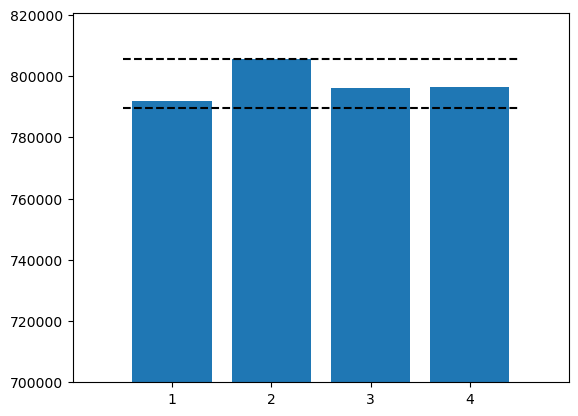

In [35]:
x=shapef_ia_redist['DISTRICT']
y=shapef_ia_redist['population']
# plt.bar(x, y)
fig, ax = plt.subplots()
district_min
ax.bar(x, y)
ax.set(xlim=(0, 5), xticks=np.arange(1, 5),
       ylim=(700000, max(y)+15000))
ax.plot([0.5, 4.5], [district_min, district_min], "k--")
ax.plot([0.5, 4.5], [district_max, district_max], "k--")

In [36]:
shapef_ia_redist

,geometry,population,xcentr_lon,ycentr_lat,DISTRICT
0,"POLYGON ((375291.238 4492157.393, 375277.354 4...",791914,425571.196624,4.569683e+06,1
1,"POLYGON ((675152.416 4607180.769, 675458.882 4...",805707,567125.419949,4.620864e+06,2
2,"POLYGON ((383020.902 4673979.464, 383014.923 4...",796174,411177.793166,4.743563e+06,3
3,"POLYGON ((606068.442 4635244.241, 605837.884 4...",796574,641569.301137,4.689396e+06,4


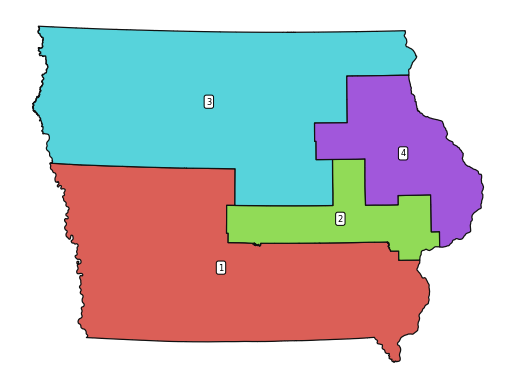

<ggplot: (336092437)>

In [37]:
distmap_by_county(shapef_ia_redist, 'DISTRICT')

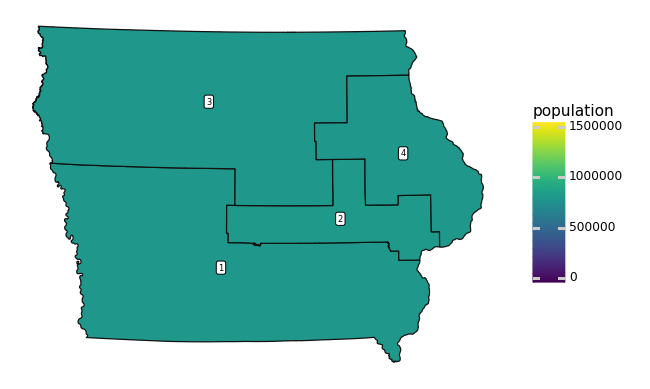

<ggplot: (336123613)>

In [38]:
map_merged_districts(shapef_ia_redist,'DISTRICT')

In [39]:
# new 4 row geodataframe with humboldt having moved from district 4 to district 3
shapef_newdissolved_temp = dissolve_by_district(shapef_counties_for_realloc)
shapef_newdissolved_temp

,geometry,population,xcentr_lon,ycentr_lat,DISTRICT
0,"POLYGON ((375291.238 4492157.393, 375277.354 4...",791914,425571.196624,4.569683e+06,1
1,"POLYGON ((675152.416 4607180.769, 675458.882 4...",805707,567125.419949,4.620864e+06,2
2,"POLYGON ((383020.902 4673979.464, 383014.923 4...",796174,411177.793166,4.743563e+06,3
3,"POLYGON ((606068.442 4635244.241, 605837.884 4...",796574,641569.301137,4.689396e+06,4


### visualizations

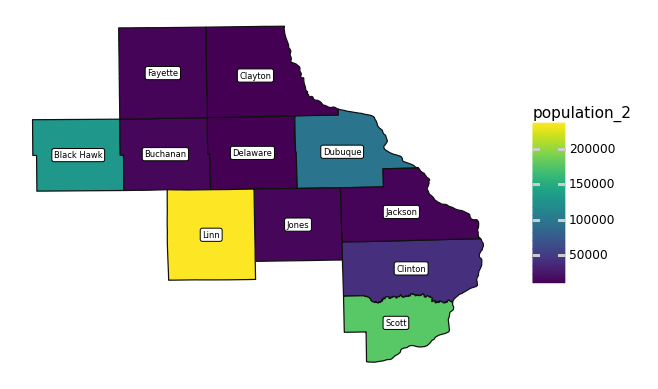

<ggplot: (322993972)>

In [40]:
#this gives an example of output of map_unmerged_districts
map_unmerged_districts(list_of_counties[3],'NAME10')

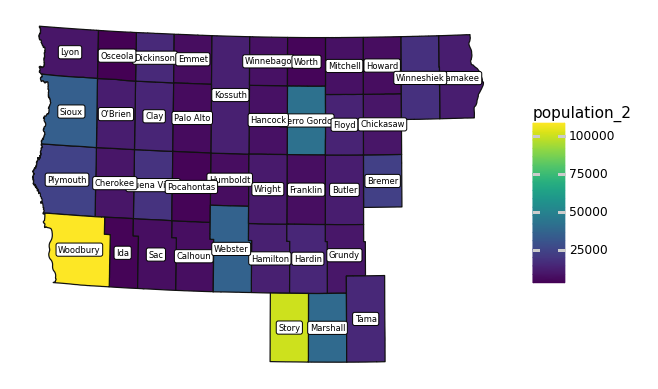

<ggplot: (336383217)>

In [41]:
map_unmerged_districts(list_of_counties[2],'NAME10')

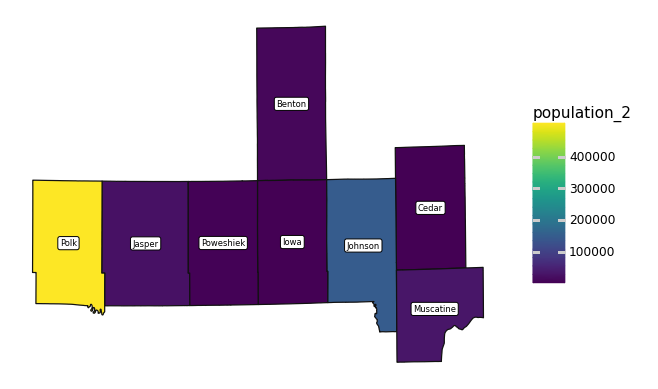

<ggplot: (323940091)>

In [42]:
map_unmerged_districts(list_of_counties[1],'NAME10')

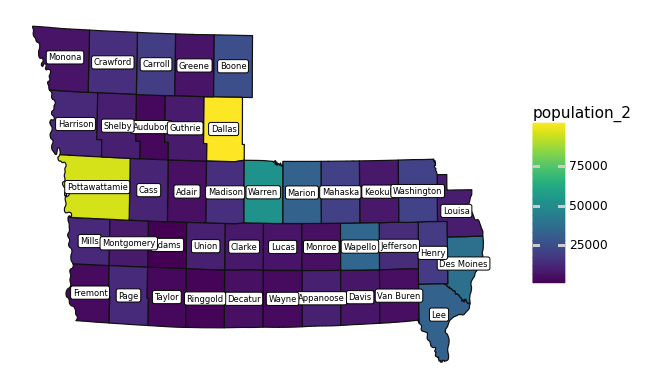

<ggplot: (322832054)>

In [43]:
map_unmerged_districts(list_of_counties[0],'NAME10')

## Chen's algorithm for reallocation

From Chen's paper:

(3a) Among all pairs of districts that border one another, identify the pair with the greatest disparity in district population. Within this pair,
let us denote the more populated district as $i$ and the less populated district as $j$.

(3b) Identify the set of all precincts currently within district $i$ that could be reassigned to district $j$ without violating the geographic contiguity of either district $i$ or $j$.

(3c) For each precinct $p$ satisfying the criterion in step 3b, define $D_p$ as precinct $p$’s geographic distance to the centroid of district $i$, minus
precinct $p$’s distance to the centroid of district $j$.

(3d) Among the set of precincts satisfying the criteria in step 3b, select the precinct, $p$, with the highest value of Dp . Reassign this precinct from
district $i$ to district $j$.